In [1]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, ZeroPadding2D, Input
from keras.models import Model
from keras.preprocessing import image
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Read train file

Get all_train: {image file name - image tag}

In [140]:
train_root_path = "data/0813/DatasetA_train_20180813"
test_root_path = "data/0813/DatasetA_test_20180813/DatasetA_test"

In [2]:
all_train = pd.read_csv(os.path.join(train_root_path, 'train.txt'), sep='\t', header=None)
all_train.columns = ['filename', 'tag']

According to image file name in all_train, get image in order  
X_train: {image in array}, in shape (image_count, height, width, channel)

### Pre-divided Train and Valid

In [34]:
Y_train = pd.read_csv(os.path.join(train_root_path, 'train_local.txt'), sep='\t', header=None)
Y_train.columns = ['filename', 'tag']

Y_valid = pd.read_csv(os.path.join(train_root_path, 'dev_local.txt'), sep='\t', header=None)
Y_valid.columns = ['filename', 'tag']

rootpath = os.path.join(train_root_path, "train") #文件夹目录
X_train = []
X_valid = []

for filename in Y_train['filename']: #遍历文件夹
    pic = image.load_img(rootpath + "/" + filename, target_size = (100, 100))
    pic = image.img_to_array(pic)
    X_train.append(pic)
    
for filename in Y_valid['filename']: #遍历文件夹
    pic = image.load_img(rootpath + "/" + filename, target_size = (100, 100))
    pic = image.img_to_array(pic)
    X_valid.append(pic)

    
    
X_train = np.array(X_train)
X_valid = np.array(X_valid)
print('Train set has {} color images'.format(X_train.shape[0]))
print('Validation set has {} color images.'.format(X_valid.shape[0]))

print('Image shape:',X_train[0].shape)

Train set has 30170 color images
Validation set has 8051 color images.
Image shape: (100, 100, 3)


### Test set loading

In [144]:
test_files = pd.read_csv(os.path.join(test_root_path, 'image.txt'), sep='\t', header=None)
test_files.columns = ['filename']

In [148]:
rootpath = os.path.join(test_root_path, "test") #文件夹目录

X_test = []

for filename in test_files['filename']: #遍历文件夹
    pic = image.load_img(rootpath + "/" + filename, target_size = (100, 100))
    pic = image.img_to_array(pic)
    X_test.append(pic)
    
X_test = np.array(X_test)
print('Test set has {} color images'.format(X_test.shape[0]))
print('Image shape:',X_test[0].shape)

Test set has 14633 color images
Image shape: (100, 100, 3)


### Attributes

tag2attr: {image tag - attribute name} pd form, merged from attr2name {attribute name}  
tag2label: {image tag - tag name} match image tag to English name  

In [4]:
tag2attr = pd.read_csv(os.path.join(train_root_path, 'attributes_per_class.txt'),sep='\t', header=None)
attr2name = pd.read_csv(os.path.join(train_root_path, 'attribute_list.txt'), sep='\t', header=None)
tag2label = pd.read_csv(os.path.join(train_root_path, 'label_list.txt'), sep='\t', header=None)
tag2label.columns = ['tag', 'label']
attr2name = attr2name.drop([0], axis=1)
attr2name.columns = ['name']
col_name = ['tag'] + attr2name['name'].tolist()
tag2attr.columns = col_name

### Embedding vector

Reading the provided word vectors 

In [5]:
word_dict = {}
embed_path = os.path.join(train_root_path, 'class_wordembeddings.txt')
with open(embed_path,'r') as f:
    for line in f:
        word, vec = line.split(' ', 1)
        word_dict[word] = np.array(list(map(float, vec.split())))

### Train and Zero-shot tags

In [6]:
train_tags = all_train['tag'].unique()
total_tags = tag2attr['tag'].unique()
zero_shot_tags = list(set(total_tags) - set(train_tags))

In [7]:
print("{} unique tags in total (Including Test Data). \n{} unique tags in Training Data. \n{} Zero-shot tags.".format(
    len(total_tags), len(train_tags), len(zero_shot_tags)))

230 unique tags in total (Including Test Data). 
190 unique tags in Training Data. 
40 Zero-shot tags.


all_train_attr: {}

In [39]:
def img_label_attr(df, tag2label=tag2label, tag2attr=tag2attr):
    Y_cate = []
    for tag in df['tag']:
        arr = [tag2label[tag2label['tag'] == tag].iloc[0,:].tolist()[1]] + tag2attr[tag2attr['tag'] == tag].iloc[0,:].tolist()
        Y_cate.append(arr)
        
    train_attr = pd.DataFrame(Y_cate)
    col_name = ['label'] + ['tag'] + attr2name['name'].tolist()
    train_attr.columns = col_name
    print('Converted {} image tags into categories'.format(train_attr.shape[0]))
    return train_attr

In [41]:
Y_train_attr = img_label_attr(Y_train)
Y_valid_attr = img_label_attr(Y_valid)

Converted 30170 image tags into categories
Converted 8051 image tags into categories


## Keras

In [10]:
from keras.layers import concatenate
from keras.applications.xception import Xception
from keras.layers import Dense, GlobalAveragePooling2D

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

### Classification Loss Model

### Tags to Int  

Convert tags (ZJLxxx) to int:  

1. There are some gap in the number after ZJL, in total there are 230 tags but the largest one is "ZJL240"  
2. Need to apply to_categorical() to get y_train

In [35]:
tag2int = {}

for tag in total_tags:
    if tag in tag2int.keys():
        print("Duplicated tags")
    else: tag2int[tag] = len(tag2int)

int2tag = {}

for tag,idx in tag2int.items():
    int2tag[idx] = tag

In [36]:
Y_train_list = list(map(lambda x: tag2int[x], Y_train['tag'].tolist()))
Y_valid_list = list(map(lambda x: tag2int[x], Y_valid['tag'].tolist()))

# one-hot encode tag types for loss calculation
y_train = to_categorical(Y_train_list, num_classes=230)
y_valid = to_categorical(Y_valid_list, num_classes=230)

In [42]:
# Embedding Labels
train_word_input = [word_dict[w] for w in Y_train_attr['label']]
valid_word_input = [word_dict[w] for w in Y_valid_attr['label']]

### Model

In [44]:
def Combine_Categorical_Model():
    """
    Image Feature Extraction
    """

    # Pre-trained Xception net
    base_model = Xception(weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Out to match semantic size
    img_out = Dense(300, activation='relu')(x)


    """
    Semantic Feature Extraction
    """
    word_input = Input(shape=(300,), name='word_input', dtype='float32')


    """
    Combine
    """
    x = concatenate([img_out, word_input])


    """
    Categorical Prediction
    """
    prediction = Dense(230, activation='softmax')(x)


    model = Model(inputs=[base_model.input, word_input], 
                  outputs=prediction)
    
    return model

In [45]:
ccm = Combine_Categorical_Model()

In [46]:
# ccm.summary()

In [47]:
ccm.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [51]:
history = ccm.fit([X_train, np.array(train_word_input)], y_train, 
        validation_data=([X_valid, np.array(valid_word_input)], y_valid), epochs=20, verbose=1)

Train on 30170 samples, validate on 8051 samples
Epoch 1/20
  128/30170 [..............................] - ETA: 1:01:00 - loss: 4.5635

KeyboardInterrupt: 

### MSE loss  

####  img->semantic space

In [52]:
def img_feature_model():
    """
    Image Feature Extraction
    """

    # Pre-trained Xception net
    base_model = Xception(weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Out to match semantic size
    img_out = Dense(300)(x)

    model = Model(inputs=base_model.input, 
                  outputs=img_out)
    
    return model

In [53]:
img2sematic = img_feature_model()

In [54]:
img2sematic.compile(optimizer='rmsprop', loss='MSE')

### Train

In [56]:
img2sematic.fit(X_train, np.array(train_word_input), 
        validation_data=(X_valid, np.array(valid_word_input)), epochs=20, verbose=1)

Train on 30170 samples, validate on 8051 samples
Epoch 1/20
  608/30170 [..............................] - ETA: 1:10:31 - loss: 0.1560

KeyboardInterrupt: 

### Inference

In [63]:
# X_test = X_valid[0:10]
Y_test = img2sematic.predict(X_test)

In [77]:
def cos_dis(v1, v2):
    return np.linalg.norm(v1-v2)

In [115]:
keys = []
values = []

for key, value in word_dict.items():
    keys.append(key)
    values.append(value)


In [137]:
from sklearn.metrics.pairwise import cosine_similarity
res = []

for v1 in Y_test:
    score = []
    for v2 in values:
        score.append(cos_dis(v1,v2))
    
    label = keys[score.index(min(score))]
    res.append(tag2label[tag2label['label'] == label]['tag'].tolist())

## PyTorch (Not Done)

In [9]:
from torch.utils.data import Dataset

class ZJL_DS(Dataset):
    def __init__(self, X, Y):
        # np array
        self.img = X
        # series
        self.tag = Y_train_attr['tag']
        self.label = Y_train_attr['label']
        # pd dataframe
        self.attr = Y_train_attr.drop(['label', 'tag'], axis=1)
        
    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):
        img_arr = self.img[idx]
        tag = self.tag[idx]
        label = self.label[idx]
        attr = self.attr.iloc[idx,:]
        info = (tag, label, attr)
        return img_arr, info
    
    def show_data(self, idx):
        img_arr = self.img[idx]
        plt.imshow(image.array_to_img(X_train[idx]))
        label = self.label[idx]
        tag = self.tag[idx]
        attr = self.attr.iloc[idx,:]
        print("Image index:{} \n\nLabel: {} \n\nTag: {} \n\nAttribute:\n{}".format(idx, label, tag, attr))
        

Image index:2505 

Label: centipede 

Tag: ZJL11 

Attribute:
is animal               1.0
is transportation       0.0
is clothes              0.0
is plant                0.0
is tableware            0.0
is device               0.0
is black                0.0
is white                0.0
is blue                 0.0
is brown                1.0
is orange               0.0
is red                  0.0
is green                0.0
is yellow               0.0
has feathers            0.0
has four legs           0.0
has two legs            0.0
has two arms            0.0
is for entertainment    0.0
is for business         0.0
is for communication    0.0
is for family           0.0
is for office use       0.0
is for personal         0.0
is gorgeous             0.0
is simple               0.0
is elegant              0.0
is cute                 0.0
is pure                 0.0
is naive                0.0
Name: 2505, dtype: float64


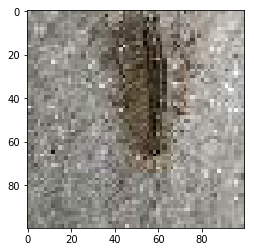

In [10]:
train_ds = ZJL_DS(X_train, Y_train_attr)

# # get train data
# img_arr, (tag, label, attr) = train_ds[32]
# label_embedding = word_dict[label]
# inspect data 
train_ds.show_data(2505)

In [60]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/liushijing/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [09:57<00:00, 78377.23it/s] 


In [101]:
class Baseline(nn.Module):
    def __init__(self, cnn, semantic_dim=300, hidden_dim=1024):
        super().__init__()
        self.cnn = cnn
        
        for p in self.cnn.parameters():
            p.requires_grad = False

        visual_dim = cnn.fc.out_features
        
        self.word_emb_transformer = nn.Sequential(*[
            nn.Linear(semantic_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, visual_dim),
            nn.ReLU(),
        ])
        
    def forward(self, image, word):
        self.cnn.eval()
        visual_emb, _ = self.cnn(image)
        semantic_emb = self.word_emb_transformer(word)

        return semantic_emb, visual_emb

In [113]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [114]:
bs = Baseline(resnet18)

In [104]:
img, (tag, label, attr) = train_ds[1]
bs(torch.LongTensor(img), torch.LongTensor(embedding_dict[label]))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got input of size [100, 100, 3] instead

In [70]:
image_dim = resnet18.fc.out_features

In [66]:
semantic_dim = 300
hidden_dim = 500

In [75]:
import torch.nn as nn
import torch

In [79]:
word_emb_transformer = nn.Sequential(
        nn.Linear(semantic_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, image_dim),
        nn.ReLU(),
    )

In [92]:
word_emb_transformer(torch.FloatTensor(embedding_dict[label])).shape

torch.Size([1000])

In [36]:
from keras.applications.xception import Xception
from keras.layers import Dense, GlobalAveragePooling2D

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

# create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(300, activation='relu')(x)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
    
# Image Part
img_model = Model(inputs=base_model.input, outputs=x)


# # and a logistic layer -- let's say we have 200 classes
# predictions = Dense(230, activation='softmax')(x)





In [55]:
base_model.input

<tf.Tensor 'input_6:0' shape=(?, ?, ?, 3) dtype=float32>

In [44]:
img_features = img_model.output
word_features = embedding_dict[label]

In [53]:
import tensorflow as tf

In [54]:
tf.constant(word_features)

<tf.Tensor 'Const:0' shape=(300,) dtype=float64>

In [56]:
pred = Dense(230, activation='softmax')(img_features + word_features)

model = Model(inputs=(base_model.input, tf.constant(word_features)), outputs=x)

ValueError: Input tensors to a Model must come from `keras.layers.Input`. Received: Tensor("Const_1:0", shape=(300,), dtype=float64) (missing previous layer metadata).

In [37]:
img_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [ ]:

# Embedding
img_model.outpus

In [ ]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ['accuracy'])

## Loss

In [98]:
import torch.nn as nn

class NewLoss(nn.Module):
    def __init__():
        super(NewLoss,self).__init__()

    def forward(self, x, y):
        pass

In [99]:
loss = Myloss()

NameError: name 'Myloss' is not defined

### Tags to Int  

Convert tags (ZJLxxx) to int:  

1. There are some gap in the number after ZJL, in total there are 230 tags but the largest one is "ZJL240"  
2. Need to apply to_categorical() to get y_train


In [178]:
len(int2tag)

230

In [171]:
tag2int = {}

for tag in total_tags:
    if tag in tag2int.keys():
        print("Duplicated tags")
    else: tag2int[tag] = len(tag2int)

In [172]:
int2tag = {}

for tag,idx in tag2int.items():
    int2tag[idx] = tag

In [173]:
Y_train_list = list(map(lambda x: tag2int[x], Y_train['tag'].tolist()))

In [179]:
y_train = to_categorical(Y_train_list, num_classes=230)

In [180]:
y_train.shape

(38221, 230)

In [100]:
from torchviz import make_dot, make_dot_from_trace

In [103]:
def cnn():
    model = Sequential()
    
    model.add(Conv2D(input_shape= (100, 100, 3), filters=32, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(input_shape= (50, 50, 32), filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(input_shape= (25, 25, 64), filters=128, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    
    model.add(Flatten())
    model.add(Dense(5000, activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(200))
    
    adam = optimizers.SGD(lr = 0.01)

    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [119]:
from keras.applications.xception import Xception
base_model = Xception(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

In [123]:
base_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ['accuracy'])

In [126]:
base_model.fit(X_train,Y_train)

ValueError: Error when checking target: expected block14_sepconv2_act to have 4 dimensions, but got array with shape (38221, 2)

In [75]:
model = cnn()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
activation_4 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_5 (Activation)    (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 128)       73856     
__________

In [117]:
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ['accuracy'])

58892288/58889256 [==============================] - 189s 3us/step


Xception initial loss = 5.5+  
Inception V3 initial loss = 5.3+  
VGG 16 initial loss = 15.00+

In [118]:
history = model.fit(X_train, y_train, shuffle=True, batch_size = 64, validation_split = 0.1, epochs = 100, verbose = 1)

Train on 34398 samples, validate on 3823 samples
Epoch 1/100
34398/34398 [==============================] - 2186s 64ms/step - loss: 6.0268 - acc: 0.0051 - val_loss: 7.4328 - val_acc: 0.0000e+00
Epoch 2/100
 6592/34398 [====>.........................] - ETA: 26:17 - loss: 5.1075 - acc: 0.0143

KeyboardInterrupt: 

In [158]:
.shape

(100, 100, 3)

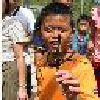

In [196]:
image.array_to_img(X_train[1].squeeze())

In [194]:
tag2attr[tag2attr['tag'] == Y_train[0:1]['tag'][0]].iloc[0,:]

tag                     ZJL1
is animal                  1
is transportation          0
is clothes                 0
is plant                   0
is tableware               0
is device                  0
is black                 0.5
is white                   1
is blue                    0
is brown                   0
is orange                  1
is red                     0
is green                   0
is yellow                  1
has feathers               0
has four legs              0
has two legs               0
has two arms               0
is for entertainment       1
is for business            0
is for communication       0
is for family              0
is for office use          0
is for personal            0
is gorgeous                0
is simple                  0
is elegant                 0
is cute                    0
is pure                    0
is naive                   0
Name: 0, dtype: object

In [197]:
pred = model.predict(X_train[0:1])
pred=pred.squeeze()
pred_list = pred.tolist()
pred_tag = int2tag[pred_list.index(max(pred_list))]
tag2attr[tag2attr['tag'] == pred_tag].iloc[0,:]

tag                     ZJL8
is animal                  1
is transportation          0
is clothes                 0
is plant                   0
is tableware               0
is device                  0
is black                   1
is white                   0
is blue                    0
is brown                   0
is orange                  0
is red                     0
is green                   0
is yellow                  0
has feathers               0
has four legs              0
has two legs               0
has two arms               0
is for entertainment       0
is for business            0
is for communication       0
is for family              0
is for office use          0
is for personal            0
is gorgeous                0
is simple                  0
is elegant                 0
is cute                    0
is pure                    0
is naive                   0
Name: 178, dtype: object

,image,tag
0,a6394b0f513290f4651cc46792e5ac86.jpeg,ZJL1


In [176]:
tag2attr[tag2attr['tag'] == "ZJL1"].iloc[0,:]

tag                     ZJL1
is animal                  1
is transportation          0
is clothes                 0
is plant                   0
is tableware               0
is device                  0
is black                 0.5
is white                   1
is blue                    0
is brown                   0
is orange                  1
is red                     0
is green                   0
is yellow                  1
has feathers               0
has four legs              0
has two legs               0
has two arms               0
is for entertainment       1
is for business            0
is for communication       0
is for family              0
is for office use          0
is for personal            0
is gorgeous                0
is simple                  0
is elegant                 0
is cute                    0
is pure                    0
is naive                   0
Name: 0, dtype: object

In [169]:
tag2attr [tag2attr['tag'] == pred_tag]

,tag,is animal,is transportation,is clothes,is plant,is tableware,is device,is black,is white,is blue,...,is for communication,is for family,is for office use,is for personal,is gorgeous,is simple,is elegant,is cute,is pure,is naive
178,ZJL8,1,0.0,0,0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0


In [93]:
import keras

vgg16 = keras.applications.vgg16.VGG16(include_top=True, weights=None, input_tensor=None, 
                               input_shape=(100, 100, 3), pooling=None, classes=200)

sgd = optimizers.SGD(lr = 0.01)

vgg16.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])


In [104]:
%%time
history = xception.fit(X_train, y_train, shuffle=True, batch_size = 64, validation_split = 0.1, epochs = 100, verbose = 1)

ValueError: Error when checking target: expected block14_sepconv2_act to have 4 dimensions, but got array with shape (38221, 200)